In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


In [80]:
# Load the dataset
df = pd.read_csv("D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/student_performance_large_dataset_new.csv")

# Clean column names
df.columns = (df.columns
              .str.strip()
              .str.replace(r"[.]+", "", regex=True)
              .str.replace(r"[^\w\s]", "", regex=True)
              .str.replace(r"\s+", "_", regex=True)
              .str.lower())

# Drop unnecessary columns
df.drop(columns=['x', 'student_id', 'exam_score'], errors='ignore', inplace=True)

# Check column names
print(df.columns)


Index(['unnamed_0', 'age', 'gender', 'study_hours_per_week',
       'preferred_learning_style', 'online_courses_completed',
       'participation_in_discussions', 'assignment_completion_rate',
       'attendance_rate', 'use_of_educational_tech',
       'self_reported_stress_level', 'time_spent_on_social_mediahoursweek',
       'sleep_hours_per_night', 'final_grade'],
      dtype='object')


In [88]:
# Define features and target
X = df.drop(columns=['final_grade'])
y = df['final_grade']

# Encode the target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Encode categorical features for tree-based models
X_tree = X.copy()
for col in X_tree.select_dtypes(include='object').columns:
    X_tree[col] = LabelEncoder().fit_transform(X_tree[col])

# One-hot encode for SVM
X_svm = pd.get_dummies(X, drop_first=True)


In [90]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [92]:
# Fit decision tree
dt = DecisionTreeClassifier(random_state=42)
path = dt.cost_complexity_pruning_path(X_train_tree, y_train_tree)
ccp_alphas = path.ccp_alphas

# Try pruning with different alpha values
best_score = 0
best_model = None

for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(model, X_train_tree, y_train_tree, cv=5)
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model = model

best_model.fit(X_train_tree, y_train_tree)
y_pred_dt = best_model.predict(X_test_tree)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test_tree, y_pred_dt))
print(confusion_matrix(y_test_tree, y_pred_dt))
print(classification_report(y_test_tree, y_pred_dt))

Decision Tree Accuracy: 0.83
[[ 154  121    0    0]
 [  50 1557  120    0]
 [   0  137  693   33]
 [   0    0   49   86]]
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       275
           1       0.86      0.90      0.88      1727
           2       0.80      0.80      0.80       863
           3       0.72      0.64      0.68       135

    accuracy                           0.83      3000
   macro avg       0.78      0.73      0.75      3000
weighted avg       0.83      0.83      0.83      3000



In [96]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

svc = SVC(probability=True)
grid_svm = GridSearchCV(svc, param_grid, cv=5)
grid_svm.fit(X_train_svm, y_train_svm)

# Predict & evaluate
y_pred_svm = grid_svm.predict(X_test_svm)

print("SVM Accuracy:", accuracy_score(y_test_svm, y_pred_svm))


SVM Accuracy: 0.5746666666666667


In [98]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_rf.fit(X_train_tree, y_train_tree)

# Predict & evaluate
y_pred_rf = grid_rf.predict(X_test_tree)

print("Random Forest Accuracy:", accuracy_score(y_test_tree, y_pred_rf))
print(confusion_matrix(y_test_tree, y_pred_rf))
print(classification_report(y_test_tree, y_pred_rf))


Random Forest Accuracy: 0.848
[[ 117  158    0    0]
 [   8 1649   70    0]
 [   0  147  709    7]
 [   0    0   66   69]]
              precision    recall  f1-score   support

           0       0.94      0.43      0.58       275
           1       0.84      0.95      0.90      1727
           2       0.84      0.82      0.83       863
           3       0.91      0.51      0.65       135

    accuracy                           0.85      3000
   macro avg       0.88      0.68      0.74      3000
weighted avg       0.85      0.85      0.84      3000



In [100]:
gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_gb = GridSearchCV(gb, param_grid_gb, cv=5)
grid_gb.fit(X_train_tree, y_train_tree)

# Predict & evaluate
y_pred_gb = grid_gb.predict(X_test_tree)

print("Gradient Boosting Accuracy:", accuracy_score(y_test_tree, y_pred_gb))
print(confusion_matrix(y_test_tree, y_pred_gb))
print(classification_report(y_test_tree, y_pred_gb))


Gradient Boosting Accuracy: 0.8786666666666667
[[ 179   96    0    0]
 [  31 1615   81    0]
 [   0  100  742   21]
 [   0    0   35  100]]
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       275
           1       0.89      0.94      0.91      1727
           2       0.86      0.86      0.86       863
           3       0.83      0.74      0.78       135

    accuracy                           0.88      3000
   macro avg       0.86      0.80      0.82      3000
weighted avg       0.88      0.88      0.88      3000



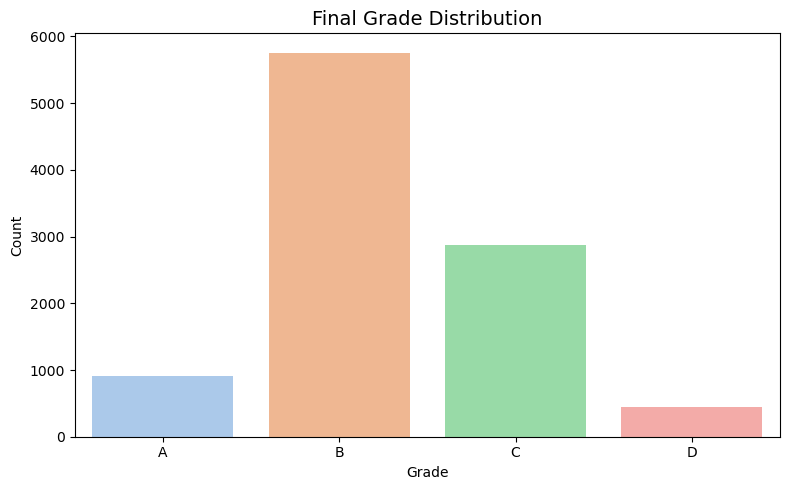

In [121]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='final_grade', hue='final_grade', order=sorted(df['final_grade'].unique()), 
              palette='pastel', legend=False)
plt.title("Final Grade Distribution", fontsize=14)
plt.xlabel("Grade")
plt.ylabel("Count")
plt.tight_layout()

# Save the figure to a specific path
plt.savefig("D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig1_final_grade_distribution.png", dpi=300)

plt.show()


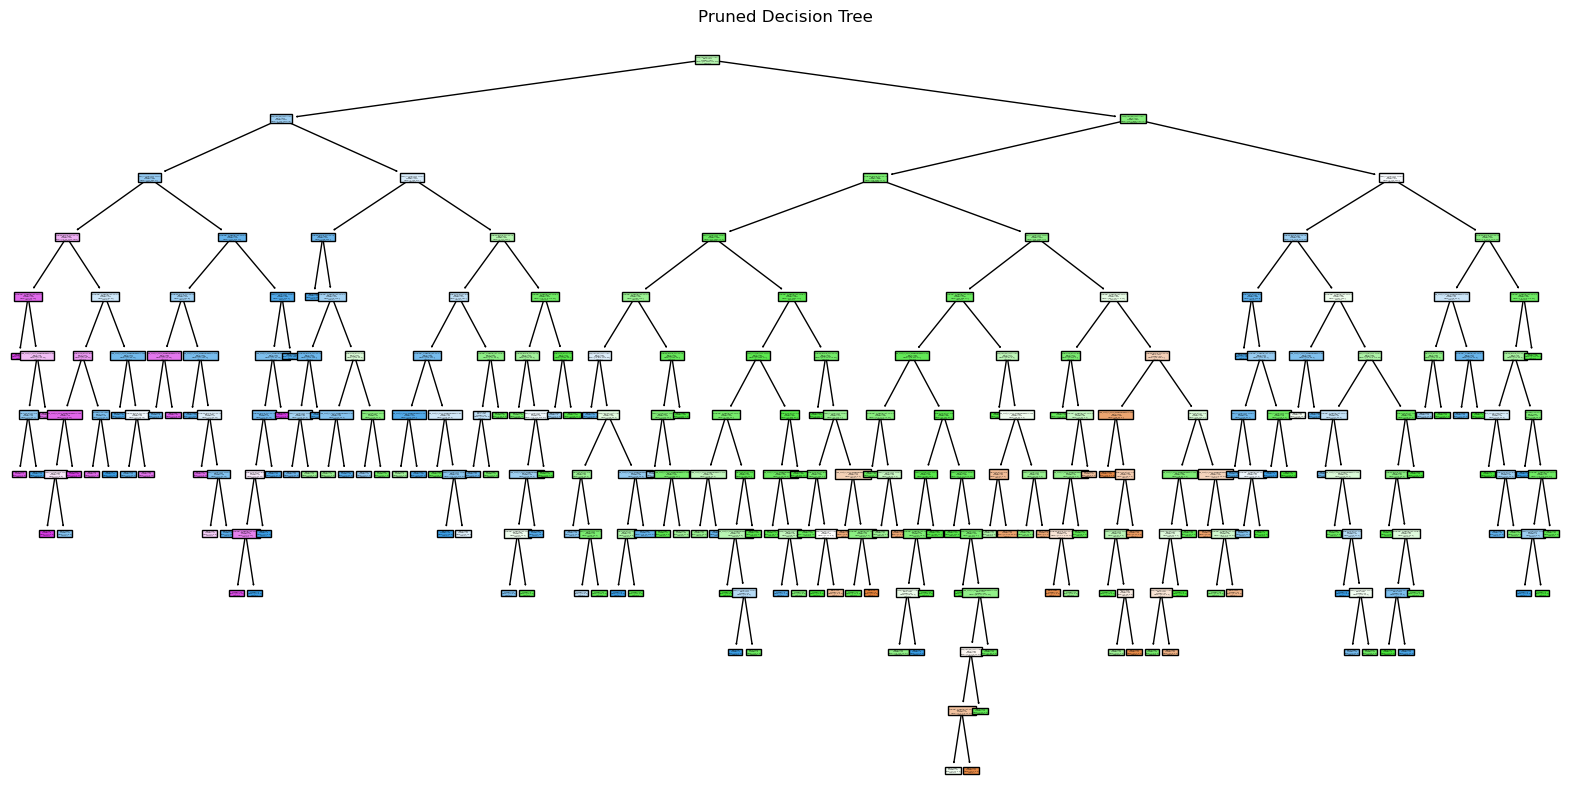

In [123]:
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X_tree.columns, class_names=le_target.classes_, filled=True)
plt.title("Pruned Decision Tree")

# Save to file (change the path as needed)
plt.savefig("D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig2_pruned_decision_tree.png", dpi=300, bbox_inches='tight')

plt.show()


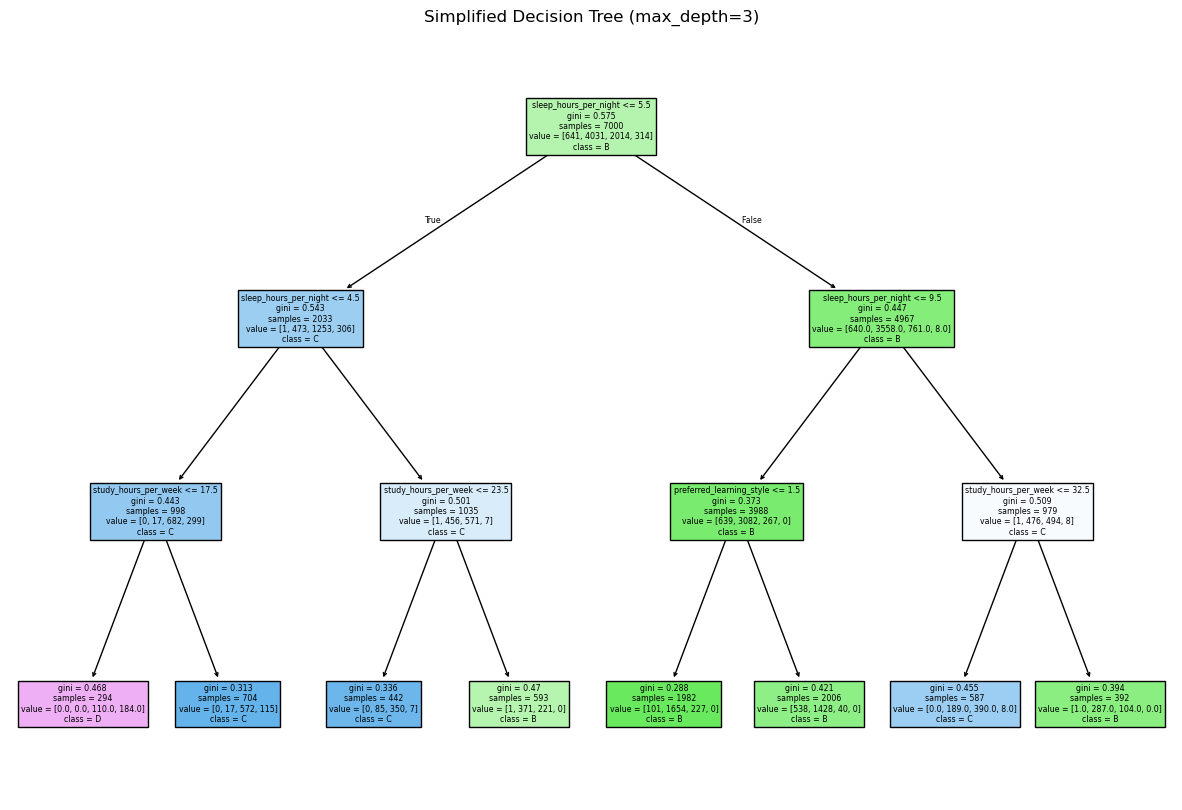

In [139]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Train a smaller decision tree
small_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
small_tree.fit(X_train_tree, y_train_tree)

# Plot and save BEFORE plt.show()
plt.figure(figsize=(15, 10))
plot_tree(
    small_tree,
    feature_names=X_tree.columns,
    class_names=le_target.classes_,
    filled=True
)
plt.title("Simplified Decision Tree (max_depth=3)")

# Save before show
plt.savefig("D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig3_Simplified_Decision_Tree.png", dpi=300, bbox_inches='tight')

# Then display
plt.show()


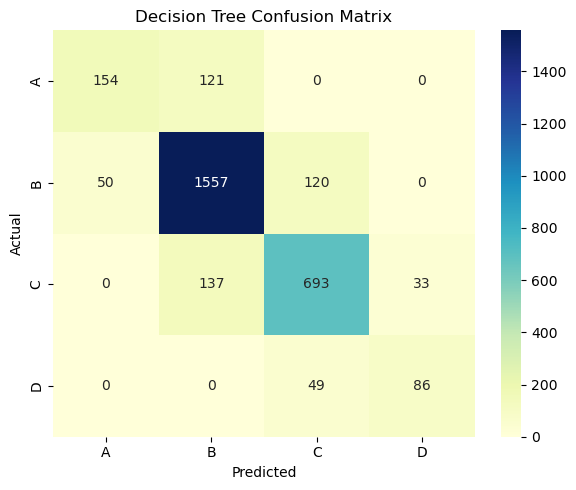

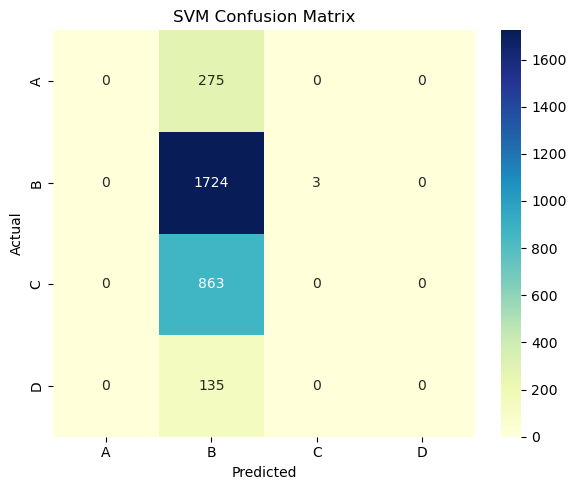

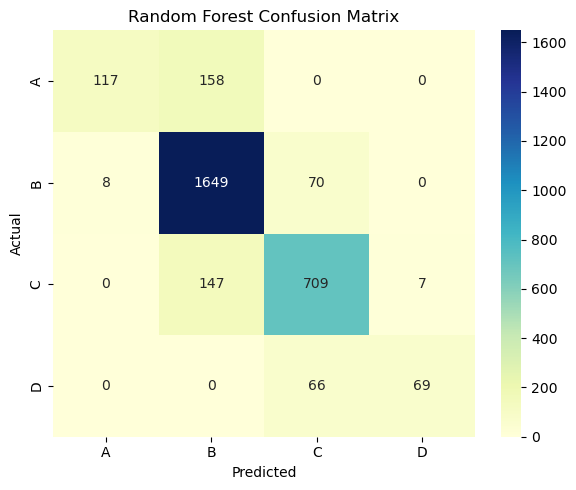

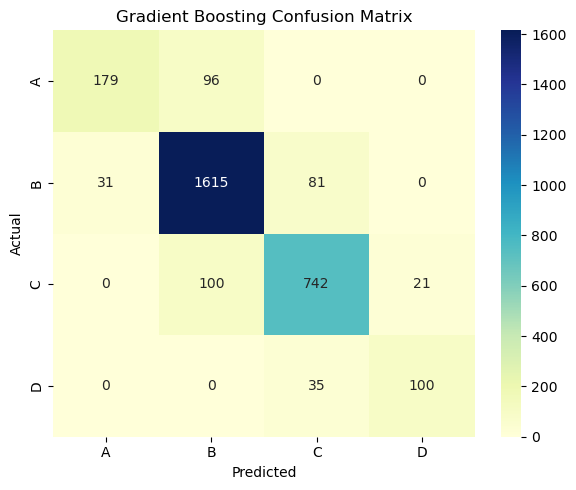

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title, filename, cmap="YlGnBu"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save only once with correct filename
    plt.show()

# Now pass the correct paths for each model
plot_conf_matrix(y_test_tree, y_pred_dt, 
                 "Decision Tree Confusion Matrix", 
                 "D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig4_Decision_Tree_Confusion_Matrix.png")

plot_conf_matrix(y_test_svm, y_pred_svm, 
                 "SVM Confusion Matrix", 
                 "D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig5_SVM_Confusion_Matrix.png")

plot_conf_matrix(y_test_tree, y_pred_rf, 
                 "Random Forest Confusion Matrix", 
                 "D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig6_Random_Forest_Confusion_Matrix.png")

plot_conf_matrix(y_test_tree, y_pred_gb, 
                 "Gradient Boosting Confusion Matrix", 
                 "D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig7_Gradient_Boosting_Confusion_Matrix.png")



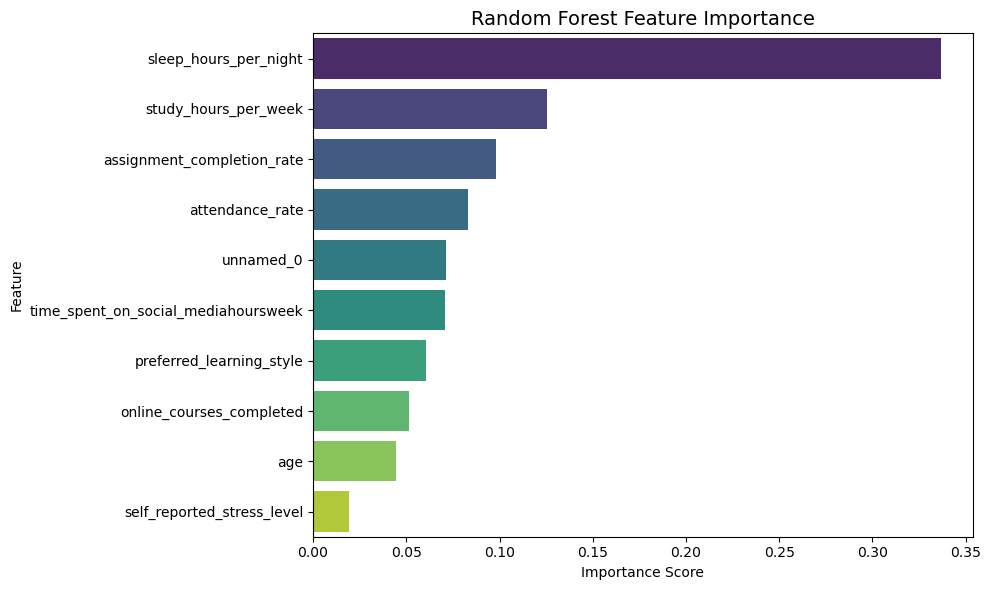

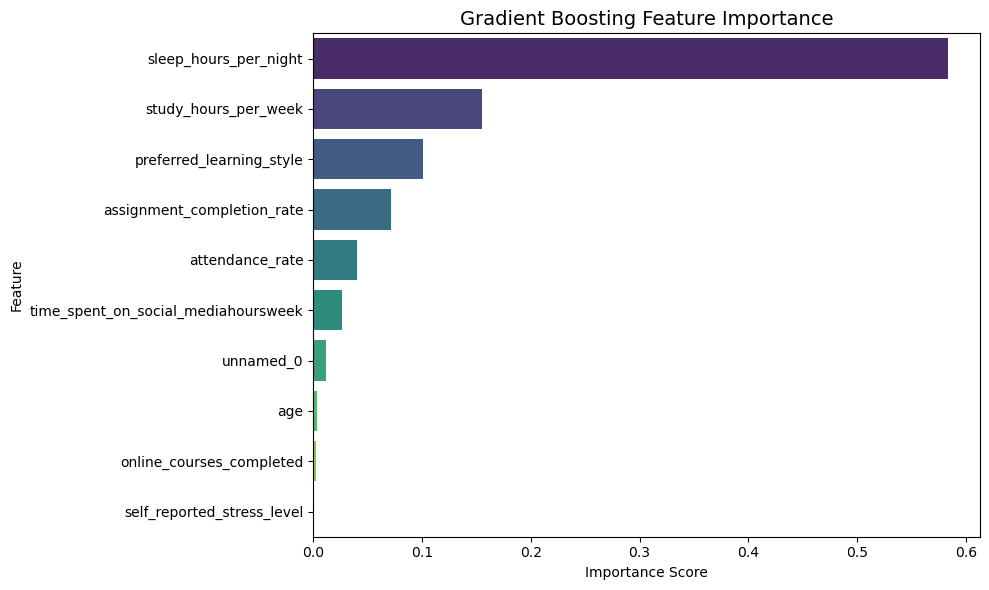

In [129]:
def plot_feature_importance(model, feature_names, title, filename, palette="viridis"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]

    # Sort descending
    top_features = np.array(feature_names)[indices]
    top_importances = importances[indices]
    sorted_idx = np.argsort(top_importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_importances[sorted_idx],
        y=top_features[sorted_idx],
        hue=top_features[sorted_idx],  # Needed to silence future warning
        dodge=False,
        palette=palette,
        legend=False  # hide redundant legend
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


# Plot importance
plot_feature_importance(grid_rf.best_estimator_, X_tree.columns,
                        "Random Forest Feature Importance",
                        "D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig8_Random_Forest_Feature_Importance.png")

plot_feature_importance(grid_gb.best_estimator_, X_tree.columns,
                        "Gradient Boosting Feature Importance",
                        "D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig9_Gradient_Boosting_Feature_Importance.png")



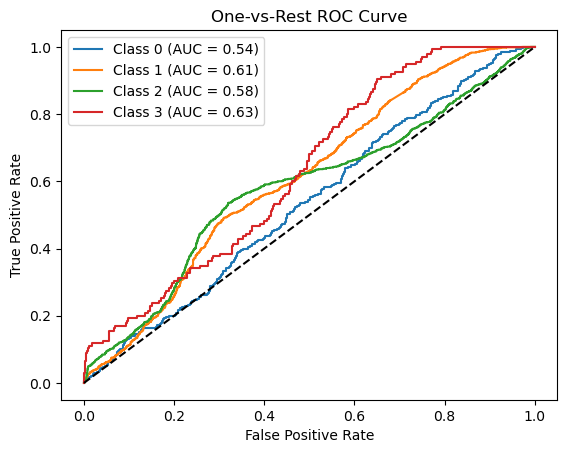

In [131]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Binarize the target
y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))
n_classes = y_bin.shape[1]

# Train One-vs-Rest SVM
ovr_svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
ovr_svm.fit(X_train_svm, label_binarize(y_train_svm, classes=np.unique(y_encoded)))

# Predict probabilities
y_score = ovr_svm.predict_proba(X_test_svm)

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test_svm, classes=np.unique(y_encoded))[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curve")
plt.legend()

plt.savefig("D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig10_One-vs-Rest ROC Curve.png", dpi=300)
plt.show()


C:\Users\easho\AppData\Local\Temp\ipykernel_10960\3586586334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="rocket")


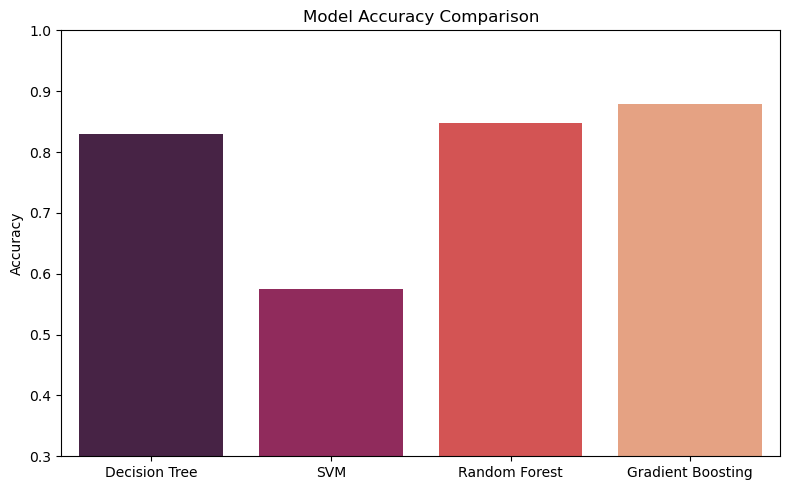

In [137]:
model_scores = {
    "Decision Tree": accuracy_score(y_test_tree, y_pred_dt),
    "SVM": accuracy_score(y_test_svm, y_pred_svm),
    "Random Forest": accuracy_score(y_test_tree, y_pred_rf),
    "Gradient Boosting": accuracy_score(y_test_tree, y_pred_gb)
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="rocket")
plt.ylabel("Accuracy")
plt.ylim(0.3, 1)
plt.title("Model Accuracy Comparison")
plt.tight_layout()

plt.savefig("D:/DU-Sem1/Period 2/Statistical Learning/Assignment 2 Folder/Fig11_Model Accuracy Comparison.png", dpi=300)
plt.show()
